# Homework 1
## COMPSCI 516 (Spring 2022)
### Adam Carriker

Copyright 2022, Adam Carriker. All rights reserved.

# Installs

In [43]:
import sys

# For conda, use the following syntax
# !conda install --yes --prefix {sys.prefix} library_name

# For pip, use the following syntax:
# !{sys.executable} -m pip install library_name
# !{sys.executable} -m pip install psycopg2-binary
# !{sys.executable} -m pip install matplotlib

     |████████████████████████████████| 7.3 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 26.8 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 19.4 MB/s eta 0:00:01
     |████████████████████████████████| 17.7 MB 27.1 MB/s eta 0:00:01
  Using cached kiwisolver-1.3.2-cp39-cp39-macosx_10_9_x86_64.whl (61 kB)


# Part 1

## Input XML Data to Database

In [ ]:
import xml.sax
import psycopg2
from psycopg2 import Error

class Article:
    def __init__(self, key, title="", journal="", year="", authors=[]):
        self.key = key
        self.title = title
        self.journal = journal
        self.year = year
        self.authors = authors
    
    # Setters        
    def set_title(self, title):
        self.title = title
        
    def set_journal(self, journal):
        self.journal = journal
        
    def set_year(self, year):
        self.year = year
        
    def set_authors(self, authors):
        self.authors = authors
        
    def add_author(self, author):
        self.authors.append(author)
    
    # Getters
    def get_key(self):
        return self.key
        
    def get_title(self):
        return self.title
        
    def get_journal(self):
        return self.journal
        
    def get_year(self):
        return self.year
    
    def get_authors(self):
        return self.authors
        
class Inproceedings:
    def __init__(self, key, title="", booktitle="", year="", authors=[]):
        self.key = key
        self.title = title
        self.booktitle = booktitle
        self.year = year
        self.authors = authors
    
    # Setters
    def set_title(self, title):
        self.title = title
        
    def set_booktitle(self, booktitle):
        self.booktitle = booktitle
        
    def set_year(self, year):
        self.year = year
        
    def set_authors(self, authors):
        self.authors = authors
        
    def add_author(self, author):
        self.authors.append(author)
        
    # Getters
    def get_key(self):
        return self.key
        
    def get_title(self):
        return self.title
        
    def get_booktitle(self):
        return self.booktitle
        
    def get_year(self):
        return self.year
    
    def get_authors(self):
        return self.authors
        

class TagHandler( xml.sax.ContentHandler ):
    def __init__(self):
        self.article = None
        self.inproceedings = None
        self.current_tag = None
        self.article_count = 0
        self.inproceedings_count = 0
        self.current_author = ''
        self.current_title = ''
        self.current_year = ''
        self.current_journal = ''
        self.current_booktitle = ''
        try:
            # Open Database Connection
            self.connection = psycopg2.connect(user="dblpuser",
                                                password="dblpus3r",
                                                host="localhost",
                                                port="5432",
                                                database="dblp")
            # Open a cursor to perform database operations
            self.cursor = self.connection.cursor()
            # Print PostgreSQL details
            print("PostgreSQL server information")
            print(self.connection.get_dsn_parameters(), "\n")
            # Executing a SQL query
            self.cursor.execute("SELECT version();")
            # Fetch result
            record = self.cursor.fetchone()
            print("You are connected to - ", record, "\n")
        except (Exception, Error) as error:
            print("Error while connecting to PostgreSQL", error)
            if self.connection is not None:
                self.cursor.close()
                self.connection.close()
                print("PostgreSQL connection is closed in __init__")           
        
    # Call when an element starts
    def startElement(self, tag, attributes):
        self.current_tag = tag
        if tag == "article":
            if self.inproceedings is not None:
                raise RuntimeException("Parse Error: start of article found before previous inproceedings end tag.")
            if self.article is not None:
                raise RuntimeException("Parse Error: start of article found before previous article end tag.")
            self.article = Article(attributes.getValue("key"), authors=[]) 
        elif tag == "inproceedings":
            if self.inproceedings is not None:
                raise RuntimeException("Parse Error: start of inproceedings found before previous inproceedings end tag.")
            if self.article is not None:
                raise RuntimeException("Parse Error: start of inproceedings found before previous article end tag.") 
            self.inproceedings = Inproceedings(attributes.getValue("key"), authors=[]) 
            
    # Call when an elements ends
    def endElement(self, tag):
        if tag == "article":            
            # Save article to database
            article_key = f"'{sanitizeString(self.article.get_key())}'"
            article_title = f"'{sanitizeString(self.article.get_title())}'" if self.article.get_title() != "" else 'NULL'
            article_journal = f"'{sanitizeString(self.article.get_journal())}'" if self.article.get_journal() != "" else 'NULL'
            article_year = f"'{sanitizeString(self.article.get_year())}'" if self.article.get_year() != "" else 'NULL'
            insert_query =  f"INSERT INTO public.\"Article\" (pubkey, title, journal, year) VALUES (" \
                            f"{article_key}, " \
                            f"{article_title}, " \
                            f"{article_journal}, " \
                            f"{article_year})"
            self.cursor.execute(insert_query)
            self.connection.commit() 
            # Save authors to database 
            for author in self.article.authors: # TODO: see if there is a way to read in unicode special characters
                insert_query =  f"INSERT INTO public.\"Authorship\" (pubkey, author) VALUES (" \
                            f"{article_key}, " \
                            f"'{sanitizeString(author)}')"
                self.cursor.execute(insert_query)
                self.connection.commit()
            self.article_count += 1
            self.article = None
        elif tag == "inproceedings": 
            # Save inproceedings to database     
            inproceedings_key = f"'{sanitizeString(self.inproceedings.get_key())}'"
            inproceedings_title = f"'{sanitizeString(self.inproceedings.get_title())}'" if self.inproceedings.get_title() != "" else 'NULL'
            inproceedings_booktitle = f"'{sanitizeString(self.inproceedings.get_booktitle())}'" if self.inproceedings.get_booktitle() != "" else 'NULL'
            inproceedings_year = f"'{sanitizeString(self.inproceedings.get_year())}'" if self.inproceedings.get_year() != "" else 'NULL'
            insert_query =  f"INSERT INTO public.\"Inproceedings\" (pubkey, title, booktitle, year) VALUES (" \
                            f"{inproceedings_key}, " \
                            f"{inproceedings_title}, " \
                            f"{inproceedings_booktitle}, " \
                            f"{inproceedings_year})"
            self.cursor.execute(insert_query)
            self.connection.commit()
            for author in self.inproceedings.authors:
                insert_query =  f"INSERT INTO public.\"Authorship\" (pubkey, author) VALUES (" \
                            f"{inproceedings_key}, " \
                            f"'{sanitizeString(author)}')"
                self.cursor.execute(insert_query)
                self.connection.commit()
            self.inproceedings_count += 1
            self.inproceedings = None
        elif self.current_tag == "author":
            if self.article is not None:
                # Check for duplicate authors
                if not self.current_author in self.article.get_authors():
                    self.article.add_author(self.current_author)
            elif self.inproceedings is not None:
                # Check for duplicate authors
                if not self.current_author in self.inproceedings.get_authors():
                    self.inproceedings.add_author(self.current_author) 
        elif self.current_tag == "title":
            if self.article is not None:
                self.article.set_title(self.current_title)
            elif self.inproceedings is not None:
                self.inproceedings.set_title(self.current_title)    
        elif self.current_tag == "year":
            if self.article is not None:
                self.article.set_year(self.current_year)
            elif self.inproceedings is not None:
                self.inproceedings.set_year(self.current_year)
        elif self.current_tag == "journal":
            if self.article is not None:
                self.article.set_journal(self.current_journal)
        elif self.current_tag == "booktitle":
            if self.inproceedings is not None:
                self.inproceedings.set_booktitle(self.current_booktitle)    
        self.current_tag = None
        self.current_author = ''
        self.current_title = ''
        self.current_year = ''
        self.current_journal = ''
        self.current_booktitle = ''
    
    # Call when document ends
    def endDocument(self):
        print(f"(end document) article count: {self.article_count}\ninproceedings count: {self.inproceedings_count}")
        if self.connection is not None:
            self.cursor.close()
            self.connection.close()
            print("PostgreSQL connection is closed in endDocument")

    # Call when a character is read
    def characters(self, content):
        if self.current_tag == "author":
            self.current_author += content
        elif self.current_tag == "title":
            self.current_title += content   
        elif self.current_tag == "year":
            self.current_year += content
        elif self.current_journal == "journal":
            self.current_author += content
        elif self.current_tag == "booktitle":
            self.current_booktitle += content
                
    def closeConnection(self):
        if self.connection is not None:
            self.cursor.close()
            self.connection.close()
            print("PostgreSQL connection is closed in closeConnection")
        

def sanitizeString(string):
    return string.replace("'","''").replace('"','""')
    
    
if( __name__ == "__main__"):
    # create an XMLReader
    parser = xml.sax.make_parser()
    # turn off namepsaces
    parser.setFeature(xml.sax.handler.feature_namespaces, 0)
    # override the default ContextHandler
    Handler = TagHandler()
    parser.setContentHandler( Handler )
    parser.parse("dblp-2022-01-01.xml") # parser.parse("dblp-test.xml") 

PostgreSQL server information
{'user': 'dblpuser', 'channel_binding': 'prefer', 'dbname': 'dblp', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 14.1 on x86_64-apple-darwin20.6.0, compiled by Apple clang version 12.0.0 (clang-1200.0.32.29), 64-bit',) 



## Run SQL Queries on Database

In [2]:
import psycopg2
from psycopg2 import Error  

class DBConnection:
    def __init__(self):        
        try:
            # Open Database Connection
            self.connection = psycopg2.connect(user="dblpuser",
                                                password="dblpus3r",
                                                host="localhost",
                                                port="5432",
                                                database="dblp")
            # Open a cursor to perform database operations
            self.cursor = self.connection.cursor()
            # Print PostgreSQL details
            print("PostgreSQL server information")
            print(self.connection.get_dsn_parameters(), "\n")
            # Executing a SQL query
            self.cursor.execute("SELECT version();")
            # Fetch result
            record = self.cursor.fetchone()
            print("You are connected to - ", record, "\n")
        except (Exception, Error) as error:
            print("Error while connecting to PostgreSQL", error)
            if self.connection is not None:
                self.cursor.close()
                self.connection.close()
                print("PostgreSQL connection is closed in __init__")     
    def execute_query(self,querystring,output_expected):
        self.cursor.execute(querystring)
        connection_ret_val = self.connection.commit()
        return self.cursor.fetchall() if output_expected else connection_ret_val        
    def close_connection(self):
        if self.connection is not None:
            self.cursor.close()
            self.connection.close()
            print("\nPostgreSQL connection is closed.")

## Q1

In [12]:
if( __name__ == "__main__"):
    DBC = DBConnection()    
    try:

        # Q1a. Count the number of tuples in Inproceedings.
        print("\nQ1a. Count the number of tuples in Inproceedings.")
        querystring = "SELECT COUNT(*) FROM public.\"Inproceedings\";"
        print("Query:")
        print(querystring)
        print("Result: ", DBC.execute_query(querystring, True)[0][0])

        # Q1b. Count the number of tuples in Article
        print("\nQ1b. Count the number of tuples in Article")
        querystring = "SELECT COUNT(*) FROM public.\"Article\";"
        print("Query:")
        print(querystring)
        print("Result: ", DBC.execute_query(querystring, True)[0][0])

        # Q1c. Count the number of tuples in Authorship
        print("\nQ1c. Count the number of tuples in Authorship")
        querystring = "SELECT COUNT(*) FROM public.\"Authorship\";"
        print("Query:")
        print(querystring)
        print("Result: ", DBC.execute_query(querystring, True)[0][0])        
    
    except (Exception, Error) as error:
        print("Error while running PostgreSQL query:", error)
        
    finally:        
        DBC.close_connection()
        

PostgreSQL server information
{'user': 'dblpuser', 'channel_binding': 'prefer', 'dbname': 'dblp', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 14.1 on x86_64-apple-darwin20.6.0, compiled by Apple clang version 12.0.0 (clang-1200.0.32.29), 64-bit',) 


Q1a. Count the number of tuples in Inproceedings.
Query:
SELECT COUNT(*) FROM public."Inproceedings";
Result:  2956396

Q1b. Count the number of tuples in Article
Query:
SELECT COUNT(*) FROM public."Article";
Result:  2738932

Q1c. Count the number of tuples in Authorship
Query:
SELECT COUNT(*) FROM public."Authorship";
Result:  18128940

PostgreSQL connection is closed.


## Q2

In [25]:
if( __name__ == "__main__"):
    DBC = DBConnection()    
    try:

        # Q2a. Add a column “Area” in the Inproceedings table.
        print("Q2a. Add a column “Area” in the Inproceedings table.")
        querystring = "ALTER TABLE public.\"Inproceedings\" ADD COLUMN \"Area\" text;"
        print("Query:")
        print(querystring)
        print("Result: ", DBC.execute_query(querystring, False))
    
    except (Exception, Error) as error:
        print("Error while running PostgreSQL query:", error)
        
    finally:        
        DBC.close_connection()
        

PostgreSQL server information
{'user': 'dblpuser', 'channel_binding': 'prefer', 'dbname': 'dblp', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 14.1 on x86_64-apple-darwin20.6.0, compiled by Apple clang version 12.0.0 (clang-1200.0.32.29), 64-bit',) 

Q2a. Add a column “Area” in the Inproceedings table.
Query:
ALTER TABLE public."Inproceedings" ADD COLUMN "Area" text;
Error while running PostgreSQL query: column "Area" of relation "Inproceedings" already exists


PostgreSQL connection is closed.


In [13]:
if( __name__ == "__main__"):    
    DBC = DBConnection()    
    all_queries = ""
    try:

        # Q2b. Populate the column “Area” following the table below. 
        #      If there is no match, then set it to “UNKNOWN”.
        print("Q2b. Populate the column “Area” following the table below")
        areas = {
            "Database":[
                "SIGMOD Conference",
                "VLDB",
                "ICDE",
                "PODS"
            ],
            "Theory":[
                "STOC",
                "FOCS",
                "SODA",
                "ICALP"
            ],
            "Systems":[
                "SIGCOMM",
                "ISCA",
                "HPCA",
                "PLDI"
            ],
            "ML-AI":[
                "ICML",
                "NIPS",
                "NeurIPS",
                "AAAI",
                "IJCAI"
            ]
        }
        # Step 1: Set Area to 'UNKNOWN' for all tuples
        print("\nStep 1: Set Area to 'UNKNOWN' for all tuples")
        querystring = "UPDATE public.\"Inproceedings\" SET \"Area\" = \'UNKNOWN\';"
        all_queries += querystring+"\n"
        print("Query:")
        print(querystring)
        print("Result: ", DBC.execute_query(querystring, False))
        
        # Step 2: Set Area to correct value based on Conference Name, given in areas table
        print("\nStep 2: Set Area to correct value based on Conference Name, given in areas table")
        for area, confNames in areas.items():
            for confName in confNames:       
                querystring =   f"UPDATE public.\"Inproceedings\""\
                                f" SET \"Area\" = \'{area}\'"\
                                f" WHERE \"booktitle\" = \'{confName}\';"
                all_queries += querystring+"\n"               
                print("Query:")
                print(querystring)
                print("Result: ", DBC.execute_query(querystring, False))
    
    except (Exception, Error) as error:
        print("Error while running PostgreSQL query:", error)
        
    finally:        
        DBC.close_connection()
        print("All queries:")
        print(all_queries)

PostgreSQL server information
{'user': 'dblpuser', 'channel_binding': 'prefer', 'dbname': 'dblp', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 14.1 on x86_64-apple-darwin20.6.0, compiled by Apple clang version 12.0.0 (clang-1200.0.32.29), 64-bit',) 

Q2b. Populate the column “Area” following the table below

Step 1: Set Area to 'UNKNOWN' for all tuples
Query:
UPDATE public."Inproceedings" SET "Area" = 'UNKNOWN';
Result:  None

Step 2: Set Area to correct value based on Conference Name, given in areas table
Query:
UPDATE public."Inproceedings" SET "Area" = 'Database' WHERE "booktitle" = 'SIGMOD Conference';
Result:  None
Query:
UPDATE public."Inproceedings" SET "Area" = 'Database' WHERE "booktitle" = 'VLDB';
Result:  None
Query:
UPDATE public."Inproceedings" SET "Ar

# Part 2

## Q3

In [7]:
if( __name__ == "__main__"):
    DBC = DBConnection()    
    try:

        # Q3a. Find the number of authors who published in each area above (do not consider "UNKNOWN"").
        print("Q3a. Find the number of authors who published in each area above \(do not consider \"UNKNOWN\"\).")
        querystring =   "SELECT I.\"Area\", COUNT(DISTINCT A.\"author\") "\
                        "FROM public.\"Inproceedings\" I , public.\"Authorship\" A "\
                        "WHERE I.pubkey = A.pubkey AND I.\"Area\" <> \'UNKNOWN\' "\
                        "GROUP BY I.\"Area\";"
        print("Query:")
        print(querystring)
        print("Result: ", DBC.execute_query(querystring, True))

        # Q3b. Find the top-10 authors who published the most number of "Database" papers.
        print("\nQ3b. Find the top-10 authors who published the most number of \"Database\" papers.")
        querystring =   "SELECT A.\"author\", COUNT(I.*) "\
                        "FROM public.\"Inproceedings\" I , public.\"Authorship\" A "\
                        "WHERE I.pubkey = A.pubkey AND I.\"Area\" = \'Database\' "\
                        "GROUP BY A.\"author\" "\
                        "ORDER BY COUNT(I.*) DESC, A.\"author\" ASC "\
                        "LIMIT 10;"
        print("Query:")
        print(querystring)
        print("Result: ", DBC.execute_query(querystring, True))

        # Q3c. Find the number of authors who published in exactly two of the four areas (do not consider "UNKNOWN").
        print("\nQ3c. Find the number of authors who published in exactly two of the four areas (do not consider \"UNKNOWN\").")
        querystring =   "SELECT Count(*) "\
                        "FROM "\
                        "    (SELECT U1.\"author\", COUNT( DISTINCT I1.\"Area\") as \"areacount\" "\
                        "    FROM public.\"Authorship\" U1, public.\"Inproceedings\" I1 "\
                        "    WHERE U1.\"pubkey\" = I1.\"pubkey\" and I1.\"Area\" <> 'UNKNOWN' "\
                        "    GROUP BY U1.\"author\") as T1 "\
                        "WHERE T1.\"areacount\" = 2; "
        print("Query:")
        print(querystring)
        print("Result: ", DBC.execute_query(querystring, True)[0][0])

        # Q3d. Find the number of authors who wrote more journal papers than conference papers (irrespective of research areas).
        print("\nQ3d. Find the number of authors who wrote more journal papers than conference papers (irrespective of research areas).")
        querystring =   "SELECT "\
                        "    (SELECT COUNT(DISTINCT U1.\"author\") "\
                        "    FROM public.\"Authorship\" U1, public.\"Article\" R1 "\
                        "    WHERE U1.\"pubkey\" = R1.\"pubkey\")  "\
                        "- "\
                        "    (SELECT COUNT(*) "\
                        "    FROM (SELECT U1.\"author\" as u1author, COUNT(R1.*) as r1count "\
                        "        FROM public.\"Authorship\" U1, public.\"Article\" R1 "\
                        "        WHERE U1.\"pubkey\" = R1.\"pubkey\" "\
                        "        GROUP BY U1.\"author\") as T1, "\
                        "        (SELECT U1.\"author\" as u1author, COUNT(I1.*) as i1count "\
                        "        FROM public.\"Authorship\" U1, public.\"Inproceedings\" I1 "\
                        "        WHERE U1.\"pubkey\" = I1.\"pubkey\" "\
                        "        GROUP BY U1.\"author\") as T2 "\
                        "WHERE  "\
                        "        T1.\"u1author\" = T2.\"u1author\" AND "\
                        "        T2.\"i1count\" >= T1.\"r1count\")  "\
                        "    AS \"cnt\";"
        print("Query:")
        print(querystring)
        print("Result: ", DBC.execute_query(querystring, True)[0][0])
        
        # Q3e. Among the authors who have published at least one “Database” paper (in any year),
        # find the top-5 authors who published the most number of papers (journal OR conference,
        # in any area) since the year 2000 (including the year 2000).
        print("\nQ3e. Among the authors who have published at least one \"Database\" paper (in any year),"\
        " find the top-5 authors who published the most number of papers (journal OR conference,"\
        " in any area) since the year 2000 (including the year 2000).")
        querystring =   "SELECT T2.\"authorinproceeding\" as \"Author\", (T2.\"inproceedingcount\" + COALESCE(T3.\"articlecount\",0)) as \"Total Papers\" "\
                        "FROM "\
                        "    (SELECT U2.\"author\" as authorinproceeding, COUNT(*) as inproceedingcount "\
                        "    FROM (SELECT DISTINCT U1.\"author\" as author "\
                        "        FROM public.\"Authorship\" U1, public.\"Inproceedings\" I1 "\
                        "        WHERE U1.\"pubkey\" = I1.\"pubkey\" and I1.\"Area\" = 'Database' "\
                        "        GROUP BY U1.\"author\") as T1, "\
                        "    public.\"Authorship\" U2, public.\"Inproceedings\" I2 "\
                        "    WHERE U2.\"pubkey\" = I2.\"pubkey\" and U2.\"author\" = T1.\"author\" and I2.\"year\" >= 2000 "\
                        "    GROUP BY U2.\"author\" "\
                        "    ORDER BY COUNT(*) DESC) as T2 "\
                        "LEFT JOIN (SELECT U3.\"author\" as authorarticle, COUNT(*) as articlecount "\
                        "        FROM public.\"Authorship\" U3, public.\"Article\" R3 "\
                        "        WHERE U3.\"pubkey\" = R3.\"pubkey\" and R3.\"year\" >= 2000 "\
                        "        GROUP BY U3.\"author\") as T3 "\
                        "ON T2.\"authorinproceeding\" = T3.\"authorarticle\" "\
                        "ORDER BY (T2.\"inproceedingcount\" + COALESCE(T3.\"articlecount\",0)) DESC "\
                        "LIMIT 5;"
        print("Query:")
        print(querystring)
        print("Result: ", DBC.execute_query(querystring, True))
    
    except (Exception, Error) as error:
        print("Error while running PostgreSQL query:", error)
        
    finally:        
        DBC.close_connection()
        

PostgreSQL server information
{'user': 'dblpuser', 'channel_binding': 'prefer', 'dbname': 'dblp', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 14.1 on x86_64-apple-darwin20.6.0, compiled by Apple clang version 12.0.0 (clang-1200.0.32.29), 64-bit',) 

Q3a. Find the number of authors who published in each area above \(do not consider "UNKNOWN"\).
Query:
SELECT I."Area", COUNT(DISTINCT A."author") FROM public."Inproceedings" I , public."Authorship" A WHERE I.pubkey = A.pubkey AND I."Area" <> 'UNKNOWN' GROUP BY I."Area";
Result:  [('Database', 16035), ('ML-AI', 52983), ('Systems', 12153), ('Theory', 8569)]

Q3b. Find the top-10 authors who published the most number of "Database" papers.
Query:
SELECT A."author", COUNT(I.*) FROM public."Inproceedings" I , public."Author

## Q4

### Q4a

PostgreSQL server information
{'user': 'dblpuser', 'channel_binding': 'prefer', 'dbname': 'dblp', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 14.1 on x86_64-apple-darwin20.6.0, compiled by Apple clang version 12.0.0 (clang-1200.0.32.29), 64-bit',) 

Q4a. Plot a linegraph with two lines, one for the number of journal papers and the other for the number of conference papers in every decade starting from 1950.
Query:
SELECT CAST(T1."Decade" as INTEGER),     CAST(T1."Conference Paper Count" as INTEGER),     CAST(T2."Journal Paper Count" as INTEGER) FROM     (SELECT FLOOR(I1."year"/10)*10 as "Decade", COUNT(*) as "Conference Paper Count"     FROM public."Inproceedings" I1     GROUP BY FLOOR(I1."year"/10)) as T1,     (SELECT FLOOR(R1."year"/10)*10 as "Decade", COUNT(*) 

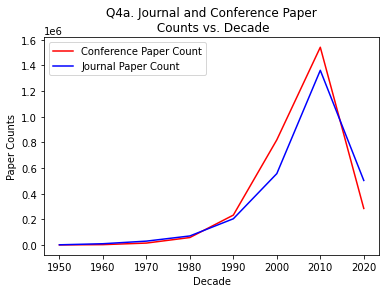


PostgreSQL connection is closed.


In [57]:
import matplotlib.pyplot as plt

if( __name__ == "__main__"):
    DBC = DBConnection()    
    try:
        # Q4a. Plot a linegraph with two lines, one for the number of journal papers and the other for the number of conference papers in every decade starting from 1950.").
        print("Q4a. Plot a linegraph with two lines, one for the number of journal papers and the other for the number of conference papers in every decade starting from 1950.")
        querystring =   "SELECT CAST(T1.\"Decade\" as INTEGER), "\
                        "    CAST(T1.\"Conference Paper Count\" as INTEGER), "\
                        "    CAST(T2.\"Journal Paper Count\" as INTEGER) "\
                        "FROM "\
                        "    (SELECT FLOOR(I1.\"year\"/10)*10 as \"Decade\", COUNT(*) as \"Conference Paper Count\" "\
                        "    FROM public.\"Inproceedings\" I1 "\
                        "    GROUP BY FLOOR(I1.\"year\"/10)) as T1, "\
                        "    (SELECT FLOOR(R1.\"year\"/10)*10 as \"Decade\", COUNT(*) as \"Journal Paper Count\" "\
                        "    FROM public.\"Article\" R1 "\
                        "    GROUP BY FLOOR(R1.\"year\"/10)) as T2 "\
                        "WHERE T1.\"Decade\" = T2.\"Decade\"; "
        print("Query:")
        print(querystring)
        queryresult = DBC.execute_query(querystring, True)
        print("Result: ", queryresult)        
                
        # Plot Results
        decades, conferencecounts, journalcounts = zip(*queryresult)
        fig, ax = plt.subplots()
        ax.plot(decades, conferencecounts, "r")
        ax.plot(decades, journalcounts, "b")
        ax.set(xlabel='Decade', ylabel='Paper Counts', title='Q4a. Journal and Conference Paper\n Counts vs. Decade')
        ax.legend(["Conference Paper Count", "Journal Paper Count"])
        fig.savefig("q4a.png")
        plt.show()
        
    
    except (Exception, Error) as error:
        print("Error while running PostgreSQL query:", error)
        
    finally:        
        DBC.close_connection()
        


### Q4b

In [60]:
import matplotlib.pyplot as plt

if( __name__ == "__main__"):
    DBC = DBConnection()    
    try:
        # Q4b. Plot a barchart showing how the average number of “collaborators” varied in each decade starting from 1950 in each of the four areas.
        print("Q4b. Plot a barchart showing how the average number of \"collaborators\" varied in each decade starting from 1950 in each of the four areas.")
        querystring =   "SELECT CAST(T7.\"decade\" as INTEGER), T7.\"decade_author_area\", CAST (AVG(T7.\"collaborator_count\") AS DOUBLE PRECISION) "\
                        "FROM "\
                        "    (SELECT T6.\"decade_author\", T6.\"decade_author_area\", T6.\"decade\", COUNT(DISTINCT U7.\"author\") as \"collaborator_count\" "\
                        "    FROM "\
                        "        (SELECT T4.\"decade_author\", T4.\"decade_inproceedings_pubkey\" as \"decade_pubkey\", T4.\"decade_author_area\", T4.\"decade\" "\
                        "        FROM "\
                        "            (SELECT T2.\"decade_author\", T3.\"decade_inproceedings_pubkey\", T2.\"decade_author_area\", T2.\"decade\" "\
                        "            FROM "\
                        "                (SELECT T1.\"decade_author\", U2.\"pubkey\" as \"decade_author_pubkey\", T1.\"decade_author_area\", T1.\"decade\" "\
                        "                FROM "\
                        "                    (SELECT DISTINCT(U1.\"author\") as \"decade_author\", I1.\"Area\" as \"decade_author_area\", FLOOR(I1.\"year\"/10)*10 as \"decade\" "\
                        "                    FROM "\
                        "                        public.\"Authorship\" U1 , public.\"Inproceedings\" I1 "\
                        "                    WHERE "\
                        "                        U1.\"pubkey\" = I1.\"pubkey\" AND "\
                        "                        I1.\"Area\" <> 'UNKNOWN' ) as T1, "\
                        "                    public.\"Authorship\" U2 "\
                        "                WHERE "\
                        "                    T1.\"decade_author\" = U2.\"author\") as T2, "\
                        "                (SELECT I3.\"pubkey\" as \"decade_inproceedings_pubkey\", FLOOR(I3.\"year\"/10)*10 as \"decade\" "\
                        "                FROM "\
                        "                    public.\"Inproceedings\" I3) as T3 "\
                        "            WHERE "\
                        "                T2.\"decade_author_pubkey\" = T3.\"decade_inproceedings_pubkey\" AND "\
                        "                T2.\"decade\" = T3.\"decade\") as T4 "\
                        "        UNION "\
                        "        SELECT T5.\"decade_author\", T5.\"decade_article_pubkey\" as \"decade_pubkey\", T5.\"decade_author_area\", T5.\"decade\" "\
                        "        FROM "\
                        "            (SELECT T2.\"decade_author\", T3.\"decade_article_pubkey\", T2.\"decade_author_area\", T2.\"decade\" "\
                        "            FROM "\
                        "                (SELECT T1.\"decade_author\", U2.\"pubkey\" as \"decade_author_pubkey\", T1.\"decade_author_area\", T1.\"decade\" "\
                        "                FROM "\
                        "                    (SELECT DISTINCT(U1.\"author\") as \"decade_author\", I1.\"Area\" as \"decade_author_area\", FLOOR(I1.\"year\"/10)*10 as \"decade\" "\
                        "                    FROM "\
                        "                        public.\"Authorship\" U1 , public.\"Inproceedings\" I1 "\
                        "                    WHERE "\
                        "                        U1.\"pubkey\" = I1.\"pubkey\" AND "\
                        "                        I1.\"Area\" <> 'UNKNOWN') as T1, "\
                        "                    public.\"Authorship\" U2 "\
                        "                WHERE "\
                        "                    T1.\"decade_author\" = U2.\"author\") as T2, "\
                        "                (SELECT R3.\"pubkey\" as \"decade_article_pubkey\", FLOOR(R3.\"year\"/10)*10 as \"decade\" "\
                        "                FROM "\
                        "                    public.\"Article\" R3) as T3 "\
                        "            WHERE "\
                        "                T2.\"decade_author_pubkey\" = T3.\"decade_article_pubkey\" AND "\
                        "                T2.\"decade\" = T3.\"decade\") as T5) as T6, "\
                        "            public.\"Authorship\" as U7 "\
                        "    WHERE "\
                        "        U7.\"pubkey\" = T6.\"decade_pubkey\" AND "\
                        "        U7.\"author\" <> T6.\"decade_author\"  "\
                        "    GROUP BY T6.\"decade_author\", T6.\"decade_author_area\", T6.\"decade\" ) as T7 "\
                        "GROUP BY T7.\"decade_author_area\", T7.\"decade\";"
        print("Query:")
        print(querystring)
        queryresult = DBC.execute_query(querystring, True)
        print("Result: ", queryresult)        
                
#         # Plot Results
#         decades, conferencecounts, journalcounts = zip(*queryresult)
#         fig, ax = plt.subplots()
#         ax.plot(decades, conferencecounts, "r")
#         ax.plot(decades, journalcounts, "b")
#         ax.set(xlabel='Decade', ylabel='Paper Counts', title='Q4a. Journal and Conference Paper\n Counts vs. Decade')
#         ax.legend(["Conference Paper Count", "Journal Paper Count"])
#         fig.savefig("q4a.png")
#         plt.show()
        
    
    except (Exception, Error) as error:
        print("Error while running PostgreSQL query:", error)
        
    finally:        
        DBC.close_connection()
        

PostgreSQL server information
{'user': 'dblpuser', 'channel_binding': 'prefer', 'dbname': 'dblp', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 14.1 on x86_64-apple-darwin20.6.0, compiled by Apple clang version 12.0.0 (clang-1200.0.32.29), 64-bit',) 

Q4b. Plot a barchart showing how the average number of "collaborators" varied in each decade starting from 1950 in each of the four areas.
Query:
SELECT CAST(T7."decade" as INTEGER), T7."decade_author_area", CAST (AVG(T7."collaborator_count") AS DOUBLE PRECISION) FROM     (SELECT T6."decade_author", T6."decade_author_area", T6."decade", COUNT(DISTINCT U7."author") as "collaborator_count"     FROM         (SELECT T4."decade_author", T4."decade_inproceedings_pubkey" as "decade_pubkey", T4."decade_author_area", T4."decade

['Database', 'ML-AI', 'Systems', 'Theory']
[[0, 6.257403189066059, 8.704719387755102, 14.473778735632184, 27.921995926680243, 60.60418158384648, 51.00180396873121], [2.3375, 4.181701030927835, 5.788508557457213, 11.577718316711263, 25.028187440532825, 54.820535003633594, 39.84050225929788], [0, 4.961748633879782, 7.371149511645379, 15.459324847814056, 28.88306299509619, 58.00673174015483, 39.014263074484944], [2.2, 5.103238866396761, 9.815813953488371, 15.853543979504696, 25.40560621411685, 35.60338243316967, 19.486095661846495]]


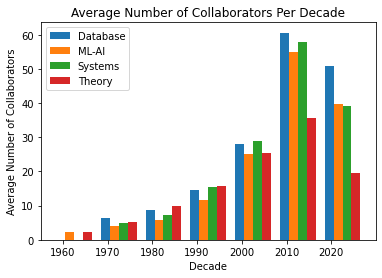

In [96]:
import numpy as np

# Plot Results
resultsdict = {}
decades = []
for decade, area, avg in queryresult:
    if area not in resultsdict.keys():
        resultsdict[area] = {}
    if decade not in decades:
        decades.append(decade)
    resultsdict[area][decade] = avg 
decades.sort()

# Make results lists
resultslists=[]
arealist = []
for area in resultsdict.keys():
    arealist.append(area)
    tmplist=[]
    for decade in decades:
        tmplist.append(resultsdict[area][decade] if decade in resultsdict[area].keys() else 0)
    resultslists.append(tmplist)
print(arealist)
print(resultslists)

N=len(decades)
ind = np.arange(N)
width = 0.20
fig, ax = plt.subplots()
for i, resultslist in enumerate(resultslists):
    ax.bar(ind+width*i, resultslist, width=width, label=arealist[i])

ax.set_ylabel('Average Number of Collaborators')
ax.set_xlabel('Decade')
ax.set_xticks(ind+width/len(arealist))
ax.set_xticklabels( decades )
ax.set_title('Average Number of Collaborators Per Decade')
ax.legend(loc='best')
fig.savefig("q4b.png")
plt.show()

### Q4c

PostgreSQL server information
{'user': 'dblpuser', 'channel_binding': 'prefer', 'dbname': 'dblp', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 14.1 on x86_64-apple-darwin20.6.0, compiled by Apple clang version 12.0.0 (clang-1200.0.32.29), 64-bit',) 

Q4c. Plot a barchart showing how the average number of authors per paper varied in each decade starting from 1950 in each of the four areas.
Query:
SELECT      CAST(T1."decade" as INTEGER),     T1."Area",      CAST(AVG(T1."author_count") as DOUBLE PRECISION) FROM     (SELECT           U1."pubkey",          I1."Area",           FLOOR(I1."year"/10)*10 as "decade",           COUNT(U1."author") as "author_count"     FROM         public."Authorship" U1 , public."Inproceedings" I1     WHERE         U1."pubkey" = I1."pubkey" 

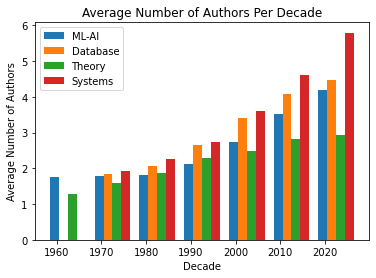


PostgreSQL connection is closed.


In [100]:
import matplotlib.pyplot as plt

if( __name__ == "__main__"):
    DBC = DBConnection()    
    try:
        # Q4c. Plot a barchart showing how the average number of authors per paper varied in each decade starting from 1950 in each of the four areas.
        print("Q4c. Plot a barchart showing how the average number of authors per paper varied in each decade starting from 1950 in each of the four areas.")
        querystring =   "SELECT  "\
                        "    CAST(T1.\"decade\" as INTEGER), "\
                        "    T1.\"Area\",  "\
                        "    CAST(AVG(T1.\"author_count\") as DOUBLE PRECISION) "\
                        "FROM "\
                        "    (SELECT  "\
                        "         U1.\"pubkey\", "\
                        "         I1.\"Area\",  "\
                        "         FLOOR(I1.\"year\"/10)*10 as \"decade\",  "\
                        "         COUNT(U1.\"author\") as \"author_count\" "\
                        "    FROM "\
                        "        public.\"Authorship\" U1 , public.\"Inproceedings\" I1 "\
                        "    WHERE "\
                        "        U1.\"pubkey\" = I1.\"pubkey\" AND "\
                        "        I1.\"Area\" <> 'UNKNOWN'  "\
                        "    GROUP BY "\
                        "        U1.\"pubkey\", I1.\"Area\", I1.\"year\") as T1 "\
                        "GROUP BY T1.\"Area\", T1.\"decade\"; "
        print("Query:")
        print(querystring)
        queryresult = DBC.execute_query(querystring, True)
        print("Result: ", queryresult)        
                
        # Plot Results
        resultsdict = {}
        decades = []
        for decade, area, avg in queryresult:
            if area not in resultsdict.keys():
                resultsdict[area] = {}
            if decade not in decades:
                decades.append(decade)
            resultsdict[area][decade] = avg 
        decades.sort()

        # Make results lists
        resultslists=[]
        arealist = []
        for area in resultsdict.keys():
            arealist.append(area)
            tmplist=[]
            for decade in decades:
                tmplist.append(resultsdict[area][decade] if decade in resultsdict[area].keys() else 0)
            resultslists.append(tmplist)
        print(arealist)
        print(resultslists)

        N=len(decades)
        ind = np.arange(N)
        width = 0.20
        fig, ax = plt.subplots()
        for i, resultslist in enumerate(resultslists):
            ax.bar(ind+width*i, resultslist, width=width, label=arealist[i])

        ax.set_ylabel('Average Number of Authors')
        ax.set_xlabel('Decade')
        ax.set_xticks(ind+width/len(arealist))
        ax.set_xticklabels( decades )
        ax.set_title('Average Number of Authors Per Decade')
        ax.legend(loc='best')
        fig.savefig("q4c.png")
        plt.show()
        
    
    except (Exception, Error) as error:
        print("Error while running PostgreSQL query:", error)
        
    finally:        
        DBC.close_connection()
        

### Q4d

In [6]:
import matplotlib.pyplot as plt

if( __name__ == "__main__"):
    DBC = DBConnection()    
    try:
        # Q4d. Using the query in Q4c as a subquery, and using a single SQL query, compute the
        # “trend” in the average number of authors per paper over each decade starting from 1950
        # in each of the four areas, in terms of the slopes in “linear regression”. Show the
        # answers as a table
        print("Q4d. Using the query in Q4c as a subquery, and using a single SQL query, compute the "\
        "“trend” in the average number of authors per paper over each decade starting from 1950 "\
        "in each of the four areas, in terms of the slopes in “linear regression”. Show the "\
        "answers as a table")
        querystring =   "SELECT  "\
                        "    T2.\"Area\" as \"area\", "\
                        "    (COUNT(T2.\"decade\")*SUM((T2.\"decade\"-1950) * T2.\"avg\") - SUM(T2.\"decade\"-1950)*SUM( T2.\"avg\") ) / "\
                        "    (COUNT(T2.\"decade\")*SUM((T2.\"decade\"-1950)*(T2.\"decade\"-1950)) - (SUM(T2.\"decade\"-1950)*SUM(T2.\"decade\"-1950)) ) as \"slope\" "\
                        "FROM "\
                        "    (SELECT  "\
                        "        CAST(T1.\"decade\" as DOUBLE PRECISION),  "\
                        "        T1.\"Area\", "\
                        "        CAST(AVG(T1.\"author_count\") as DOUBLE PRECISION) "\
                        "    FROM "\
                        "        (SELECT  "\
                        "            U1.\"pubkey\", "\
                        "            I1.\"Area\",  "\
                        "            FLOOR(I1.\"year\"/10)*10 as \"decade\",  "\
                        "            COUNT(U1.\"author\") as \"author_count\" "\
                        "        FROM "\
                        "            public.\"Authorship\" U1 , public.\"Inproceedings\" I1 "\
                        "        WHERE "\
                        "            U1.\"pubkey\" = I1.\"pubkey\" AND "\
                        "            I1.\"Area\" <> 'UNKNOWN'  "\
                        "        GROUP BY "\
                        "            U1.\"pubkey\", I1.\"Area\", I1.\"year\") as T1 "\
                        "    GROUP BY T1.\"Area\", T1.\"decade\") as T2 "\
                        "GROUP BY T2.\"Area\";" 
        print("Query:")
        print(querystring)
        queryresult = DBC.execute_query(querystring, True)
        print("Result: ", queryresult)        
        
        areas, slopes = zip(*queryresult)
        print("\nAREA \t\t| SLOPE")
        print("___________________________________________")
        for area, slope in zip(areas,slopes):
            print(f"{area}   \t| {slope}")
        print(f"\nArea {areas[slopes.index(max(slopes))]} has a maximum slope of {max(slopes)}")
        print(f"Area {areas[slopes.index(min(slopes))]} has a minimum slope of {min(slopes)}")
        
    except (Exception, Error) as error:
        print("Error while running PostgreSQL query:", error)
        
    finally:        
        DBC.close_connection()
        

PostgreSQL server information
{'user': 'dblpuser', 'channel_binding': 'prefer', 'dbname': 'dblp', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 14.1 on x86_64-apple-darwin20.6.0, compiled by Apple clang version 12.0.0 (clang-1200.0.32.29), 64-bit',) 

Q4d. Using the query in Q4c as a subquery, and using a single SQL query, compute the “trend” in the average number of authors per paper over each decade starting from 1950 in each of the four areas, in terms of the slopes in “linear regression”. Show the answers as a table
Query:
SELECT      T2."Area" as "area",     (COUNT(T2."decade")*SUM((T2."decade"-1950) * T2."avg") - SUM(T2."decade"-1950)*SUM( T2."avg") ) /     (COUNT(T2."decade")*SUM((T2."decade"-1950)*(T2."decade"-1950)) - (SUM(T2."decade"-1950)*SUM(T2."decade"-